In [62]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [63]:
vehiculo = 'DA01'

In [64]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

372

In [65]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [66]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [67]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

58

In [68]:
contenido_filtrado

['2025-11-05 18-18-49.tlog',
 '2025-11-05 18-27-28.tlog',
 '2025-11-05 19-17-43.tlog',
 '2025-11-05 19-46-13.tlog',
 '2025-11-05 20-14-51.tlog',
 '2025-11-05 20-50-05.tlog',
 '2025-11-05 21-36-25.tlog',
 '2025-11-05 21-44-56.tlog',
 '2025-11-10 17-58-24.tlog',
 '2025-11-10 18-09-31.tlog',
 '2025-11-10 18-36-24.tlog',
 '2025-11-10 19-00-28.tlog',
 '2025-11-10 19-01-27.tlog',
 '2025-11-10 19-09-27.tlog',
 '2025-11-10 19-12-06.tlog',
 '2025-11-10 19-15-14.tlog',
 '2025-11-10 19-19-27.tlog',
 '2025-11-10 19-25-59.tlog',
 '2025-11-10 20-13-44.tlog',
 '2025-11-10 21-02-15.tlog',
 '2025-11-10 21-15-57.tlog',
 '2025-11-10 22-30-02.tlog',
 '2025-11-10 23-18-58.tlog',
 '2025-11-10 23-58-24.tlog',
 '2025-11-11 00-53-40.tlog',
 '2025-11-11 03-00-42.tlog',
 '2025-11-11 03-24-14.tlog',
 '2025-11-11 03-45-25.tlog',
 '2025-11-11 04-18-28.tlog',
 '2025-11-11 05-08-07.tlog',
 '2025-11-11 05-26-20.tlog',
 '2025-11-11 18-57-45.tlog',
 '2025-11-11 19-23-04.tlog',
 '2025-11-11 19-44-42.tlog',
 '2025-11-11 2

In [69]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [70]:
lineas, names = leer_logs(contenido_filtrado)
lineas

[<LINESTRING (-63.03 -17.275, -63.03 -17.275, -63.03 -17.275, -63.03 -17.275,...>,
 <LINESTRING (-63.03 -17.275, -63.03 -17.275, -63.03 -17.275, -63.03 -17.275,...>,
 <LINESTRING (-63.03 -17.275, -63.03 -17.275, -63.03 -17.275, -63.03 -17.275,...>,
 <LINESTRING (-63.03 -17.275, -63.03 -17.275, -63.03 -17.275, -63.03 -17.275,...>,
 <LINESTRING (-63.03 -17.262, -63.03 -17.262, -63.03 -17.262, -63.03 -17.262,...>,
 <LINESTRING (-63.029 -17.261, -63.029 -17.261, -63.029 -17.261, -63.029 -17....>,
 <LINESTRING (-63.031 -17.258, -63.031 -17.258, -63.031 -17.258, -63.031 -17....>,
 <LINESTRING (-63.031 -17.258, -63.031 -17.258, -63.031 -17.258, -63.031 -17....>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-62.968 -17.299, -62.968 -17.299, -62.968 -17.299, -62.968 -17....>,
 <LINESTRING (-62.968 -17.299, -62.968 -17.299, -62.968 -17.299, -62.968 -17....>,
 <LINESTRING (-62.983 -17.294, -62.983 -17.294, -62.983 -17.294, -62.983 -17....>,
 <LI

In [71]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-11-05 18-18-49.tlog,"LINESTRING (-63.02966 -17.27501, -63.02966 -17..."
1,2025-11-05 18-27-28.tlog,"LINESTRING (-63.02968 -17.27501, -63.02968 -17..."
2,2025-11-05 19-17-43.tlog,"LINESTRING (-63.02968 -17.27503, -63.02968 -17..."


In [72]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [73]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [74]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [75]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-11-05 18-18-49.tlog,"LINESTRING (-63.02966 -17.27501, -63.02966 -17...",25,DA01
1,2025-11-05 18-27-28.tlog,"LINESTRING (-63.02968 -17.27501, -63.02968 -17...",1232,DA01
2,2025-11-05 19-17-43.tlog,"LINESTRING (-63.02968 -17.27503, -63.02968 -17...",3228,DA01


<Axes: >

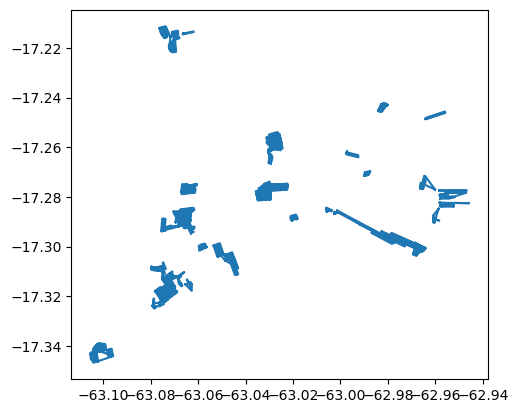

In [76]:
gdf_lines.plot()

In [77]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

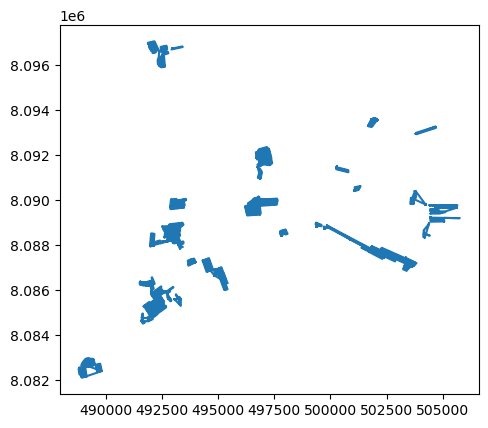

In [78]:
gdf_lines_utm.plot()

In [79]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [80]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-11-05 18-18-49.tlog,"LINESTRING (496847.694 8090021.686, 496847.694...",25,DA01,0
1,2025-11-05 18-27-28.tlog,"LINESTRING (496845.515 8090021.696, 496845.493...",1232,DA01,0
2,2025-11-05 19-17-43.tlog,"LINESTRING (496845.451 8090019.251, 496845.473...",3228,DA01,0
3,2025-11-05 19-46-13.tlog,"LINESTRING (496843.697 8090020.822, 496843.697...",394,DA01,0
4,2025-11-05 19-46-13.tlog,"LINESTRING (496843.910 8090022.448, 496843.910...",4132,DA01,0
...,...,...,...,...,...
57,2025-11-12 21-02-01.tlog,"LINESTRING (493422.289 8087946.130, 493421.663...",97,DA01,0
58,2025-11-12 23-07-06.tlog,"LINESTRING (493305.797 8087824.401, 493305.776...",98,DA01,0
59,2025-11-13 00-43-11.tlog,"LINESTRING (489254.172 8082584.786, 489254.119...",3642,DA01,0
60,2025-11-13 05-22-14.tlog,"LINESTRING (489253.589 8082583.292, 489253.663...",2245,DA01,0


In [81]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)